In [1]:
import numpy as np
import os
import sys
import pickle
from scipy.optimize import least_squares
from scipy.interpolate import interp1d, interp2d
from matplotlib import pyplot as plt

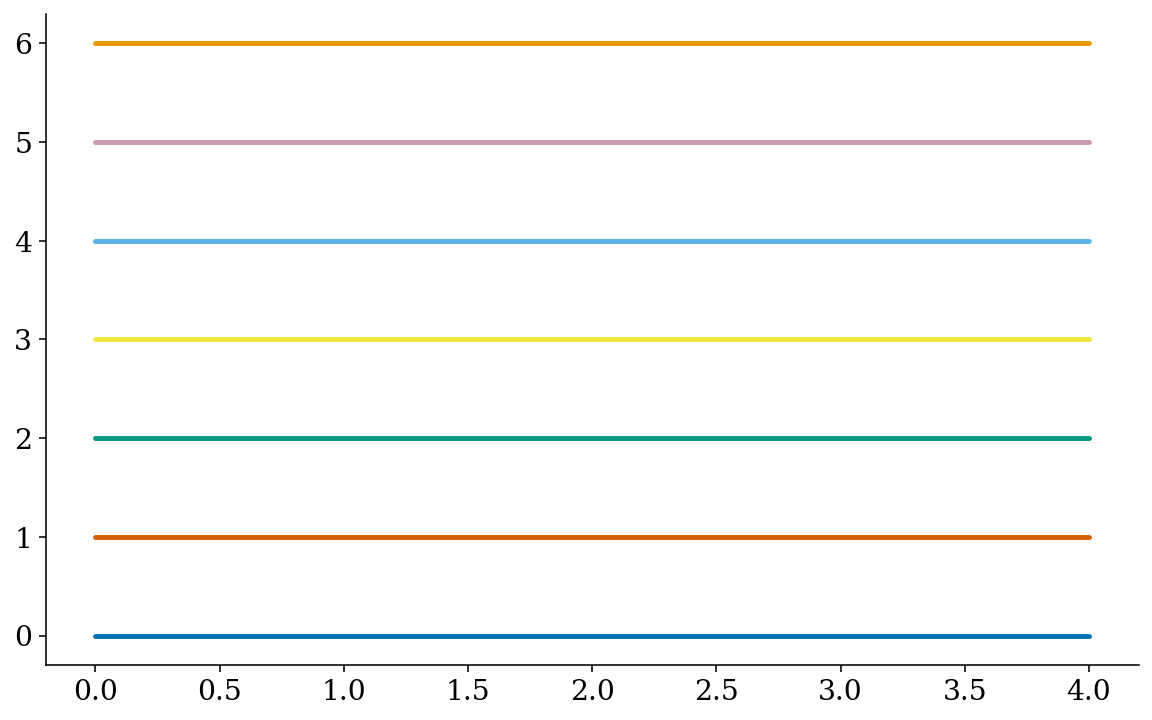

In [2]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot
import matplotlib
from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (10,6)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
for i,c in enumerate(colorblind_colors):
    plt.plot((i)*np.ones(5),c=c)

$$ J(\beta) = \frac{1}{2}||W (y-X\beta)||^2 + \frac{1}{2}\gamma ||S\beta||^2$$

$$
J(\beta) = \frac{1}{2}(y-X\beta)^T W (y-X\beta) + \frac{1}{2} \gamma \beta^T S^T S \beta
$$

$$
J(\beta) = \frac{1}{2} y^T W y - y^T W X\beta + \frac{1}{2} \beta^T X^T W X\beta + \frac{1}{2}\gamma \beta^T S^T  \beta
$$

$$
J(\beta) = \frac{1}{2} \beta^T (X^T W X + \gamma S^T S) \beta - (y^T W X) \beta + \frac{1}{2}y^T W y
$$

Subject to: 
$$
y(1) = 0 \\
y'(0) = 0
$$

$$
C \beta = 0 \\
C = \begin{bmatrix} 
    f_0(1) & f_1(1) & \dots & f_N(1) \\
    f'_0(0) & f'_1(0) & \dots & f'_N(0) \\
    \end{bmatrix}
$$

$$
\begin{align}
L(\beta, \lambda) &= J(\beta) + \lambda^TC\beta \\
   &= \frac{1}{2} \beta^T (X^T W X + \gamma S^T S) \beta - (y^T W X - \lambda^T C) \beta + \frac{1}{2}y^T W y
\end{align}
    $$

$$
\frac{\partial L}{\partial \beta} = (X^T W X + \gamma S^T S) \beta - X^T W y + C^T \lambda = 0 \\ 
$$

$$
(X^T W X + \gamma S^T S) \beta  + C^T \lambda = X^T W y \\ 
C\beta = 0
$$


$$
\begin{bmatrix}
(X^T W X + \gamma S^T S) & C^T \\
C & 0
\end{bmatrix} 
\begin{bmatrix}
\beta \\
\lambda
\end{bmatrix}
 = 
\begin{bmatrix}
X^T W y \\
0
\end{bmatrix}
$$


In [3]:
with open(os.path.expanduser('~/plasma-profile-predictor/pca_fitters.pkl'),'rb') as f:
    full_pca_fitter = pickle.load(f, encoding='latin1')
with open(os.path.expanduser('~/plasma-profile-predictor/pca_kernels.pkl'),'rb') as f:
    kernels = pickle.load(f, encoding='latin1')


In [4]:
for sig in kernels.keys():
    kernels[sig]['variance'] = full_pca_fitter[sig].explained_variance_

In [5]:
def naive_pca_fit(xq,x_meas,y_meas,sig,order=None,var_cutoff=.95):
    x_interp = np.linspace(0,1,33)
    y_interp = np.interp(x_interp,x_meas,y_meas)
    m = np.mean(y_interp)
    y_interp -= m
    var = np.cumsum(kernels[sig]['variance'])/np.sum(kernels[sig]['variance'])
    if order is None:
        order = np.where(np.cumsum(kernels[sig]['variance'])/np.sum(kernels[sig]['variance'])>var_cutoff)[0][0]
    K = kernels[sig][order]
    xg = np.linspace(0,1,33)
    y_interp = np.matmul(y_interp,K)
    y_interp = np.interp(xq,xg,y_interp) + m
    return y_interp

In [22]:
xg = np.linspace(0,1,33)
basis_fns = {}
df0 = {}
f1 = {}
for sig in full_pca_fitter.keys():
    basis_fns[sig] = [lambda x: np.ones(x.shape)]
    df0[sig] = [0]
    f1[sig] = [1]
    for arr in full_pca_fitter[sig].components_:
        basis_fns[sig].append(interp1d(xg,arr,kind='cubic',fill_value='extrapolate'))
        df0[sig].append(np.gradient(arr,xg,edge_order=2)[0])
        f1[sig].append(arr[-1])
             
             

In [98]:
def fancy_pca_fit(xq,x_meas,y_meas,y_err,sig,order=None,var_cutoff=.95,gamma=1e-2):
    fitter = full_pca_fitter[sig]
    if order is None:
        order = np.where(np.cumsum(fitter.explained_variance_ratio_)>var_cutoff)[0][0]
    S = np.diag(np.abs(np.log(np.concatenate(([1],fitter.explained_variance_ratio_[:order])))))
    W = np.diag(1/y_err)
    X = np.stack([basis_fns[sig][i](x_meas) for i in range(order+1)],axis=1)
    C = np.array([df0[sig][:order+1],f1[sig][:order+1]])
    nconst = C.shape[0]
    
    rhs = np.hstack([np.matmul(np.matmul(X.T,W),y_meas),np.zeros(C.shape[0])])
    XTWX = np.matmul(np.matmul(X.T,W),X) + gamma*(order+1)*np.matmul(S.T,S)
    A = np.vstack([np.hstack([XTWX,C.T]),np.hstack([C,np.zeros((nconst,nconst))])])
#     Ainv = np.linalg.inv(A)
    beta = np.linalg.solve(A,rhs)
    B = beta[:order+1]
    L = beta[order+1:]
    y_interp = np.zeros(xq.size)
    for i in range(order+1):
        y_interp += B[i]* basis_fns[sig][i](xq)
    RSS = np.sum((np.interp(x_meas,xq,y_interp)-y_meas)**2/y_err**2)
    return y_interp, B, L, RSS

In [48]:
order = 3
nconst = 2
X = np.ones((10,order))
W = np.ones((10,10))
y = np.ones(10)
C = np.ones((nconst,order))
S = np.ones((order,order))
gamma = 0.1
XTWX = np.matmul(np.matmul(X.T,W),X) + gamma*(order+1)*np.matmul(S.T,S)
XTWX.shape
np.vstack([np.hstack([XTWX,C.T]),np.hstack([C,np.zeros((nconst,nconst))])])

array([[101.2, 101.2, 101.2,   1. ,   1. ],
       [101.2, 101.2, 101.2,   1. ,   1. ],
       [101.2, 101.2, 101.2,   1. ,   1. ],
       [  1. ,   1. ,   1. ,   0. ,   0. ],
       [  1. ,   1. ,   1. ,   0. ,   0. ]])

In [7]:

def mtanh(r, p):
    height = p[0] #
    sep = p[1] # offset
    slope = p[2]
    pos = p[3]
    wid = p[4]

    a = (height-sep)/2
    x = 4*(pos-r)/wid
    m = slope*wid/4
    y = a*(((1 - m*x)*np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))+1) + sep
    return y


def mtanh_res(params, x_data, y_data, y_err):
    y_model = mtanh(x_data, params)
    res = (y_data - y_model)/y_err
    return res


def fit_mtanh(x_data, y_data, y_err=None):

    if y_err is None:
        y_err = np.ones(y_data.shape)

    p0 = np.array([1.0, 0.1, 2, 1.0, 0.01])
    pmin = np.array([0.1, 0.000, -10, 0.85, 0.01])
    pmax = np.array([np.inf, 0.5, 10, 1.15, np.inf])

    kwargs = {'x_data': x_data,
              'y_data': y_data,
              'y_err': y_err}
    fit_out = least_squares(mtanh_res,
                            p0,
                            jac='2-point',
                            bounds=(pmin, pmax),
                            method='trf',
                            ftol=1e-08,
                            xtol=1e-08,
                            gtol=1e-08,
                            x_scale=1.0,
                            loss='linear',
                            f_scale=1.0,
                            diff_step=None,
                            tr_solver=None,
                            tr_options={},
                            jac_sparsity=None,
                            max_nfev=200,
                            verbose=0,
                            args=(),
                            kwargs=kwargs)
    return fit_out.x


def fit_profile(xq, x_data, y_data, y_err=None):
    if y_err is None:
        y_err = np.ones(y_data.shape)

    p = fit_mtanh(x_data, y_data, y_err)
    y_interp = mtanh(xq, p)
    RSS = np.sum((y_meas-mtanh(x_meas,p))**2/y_err**2)
    return y_interp, RSS


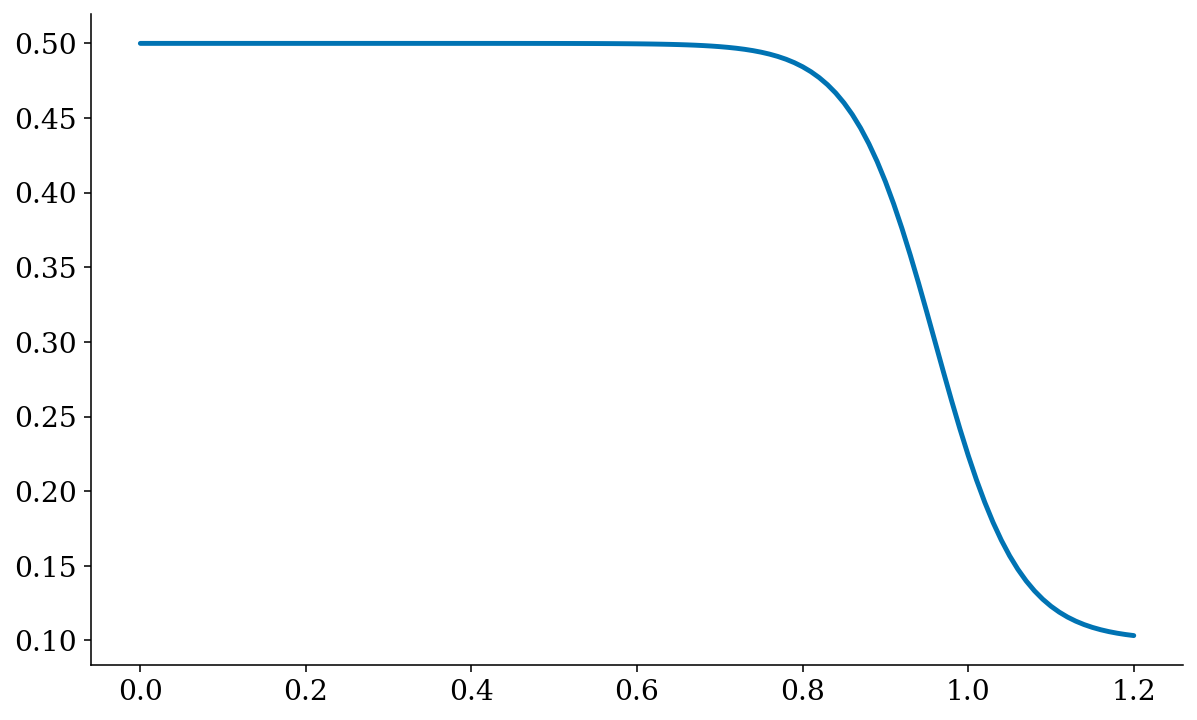

In [8]:
sigma=0.5
l1=.5
l2=.1
lw=0.1
x0=.96
    
    
def lfunc(x):
    return (l1 + l2)/2 - (l1 - l2)/2*np.tanh((x-x0)/lw)

x = np.linspace(0,1.2,121)
plt.plot(x,lfunc(x))

In [9]:
def square_exp_kernel(x1,x2, sigma=1, l=0.3):
    return sigma**2*np.exp(-(x1.reshape((x1.size,1))-x2.reshape((1,x2.size)))**2/(2*l**2))


def gibbs_kernel(x1,x2, sigma=0.5, l1=.3,l2=.1,lw=0.05, x0=.96):
    
    
    def lfunc(x):
        return (l1 + l2)/2 - (l1 - l2)/2*np.tanh((x-x0)/lw)
    
    den = lfunc(x1).reshape((x1.size,1))**2+lfunc(x2).reshape((1,x2.size))**2
    prefactor = sigma**2*np.sqrt(2*lfunc(x1).reshape((x1.size,1))*lfunc(x2).reshape((1,x2.size))/den)
    return prefactor*np.exp(-(x1.reshape((x1.size,1))-x2.reshape((1,x2.size)))**2/den)
    
    
def GPR(xq,x,y,y_err,kernel=gibbs_kernel):
    y_err[np.abs(y_err)<1e-10] = 1e30
    sigma_n = np.diag(y_err)
    
    K1 = kernel(xq,x)
    K2 = kernel(x,x)
    K3 = kernel(xq,xq)

    temp = np.linalg.inv(K2+sigma_n)
    mu = np.matmul(np.matmul(K1,temp),y)
    unc = K3 - np.matmul(np.matmul(K1,temp),K1.T)
    RSS = np.sum((np.interp(x,xq,mu)-y)**2/y_err**2)

    return mu, unc, RSS

In [10]:
test_data_path = '/scratch/gpfs/jabbate/full_data_with_error/test_data.pkl' 
rt_test_data_path = '/scratch/gpfs/jabbate/test_rt/final_data.pkl'

with open(test_data_path,'rb') as f:
    offline_data = pickle.load(f, encoding='latin1')
    
with open(rt_test_data_path,'rb') as f:
    rt_data = pickle.load(f, encoding='latin1')

In [11]:
shots = list(offline_data.keys())

In [12]:
for shot,shotdata in rt_data.items():
    sigs = ['cerquick_temp_preinterp','cerquick_rotation_preinterp','psi_cerquick_EFITRT1']
    for sig in sigs:
        if sig in shotdata:
            shotdata[sig] = shotdata[sig].T


In [13]:
def get_data(shot,time,sig):
    sig_rt = {'temp':'thomson_temp_preinterp',
             'dens':'thomson_dens_preinterp',
             'itemp':'cerquick_temp_preinterp',
             'rotation':'cerquick_rotation_preinterp'}
    rt_coords = {'temp':'psi_thomson_temp_EFITRT1',
             'dens':'psi_thomson_dens_EFITRT1',
             'itemp':'psi_cerquick_EFITRT1',
             'rotation':'psi_cerquick_EFITRT1'}
    if sig not in offline_data[shot].keys() or sig_rt[sig] not in rt_data[shot].keys():
        return None
    
    rttimes = np.argmin(abs(rt_data[shot]['time']-time))
    offlinetimes = np.argmin(abs(offline_data[shot]['time']-time))
    return {'zipfit':offline_data[shot][sig][offlinetimes],
           'rt':rt_data[shot][sig_rt[sig]][rttimes],
           'psi':rt_data[shot][rt_coords[sig]][rttimes],
           'times':{'rt':rt_data[shot]['time'][rttimes],
                   'offline':offline_data[shot]['time'][offlinetimes]}}
    
    

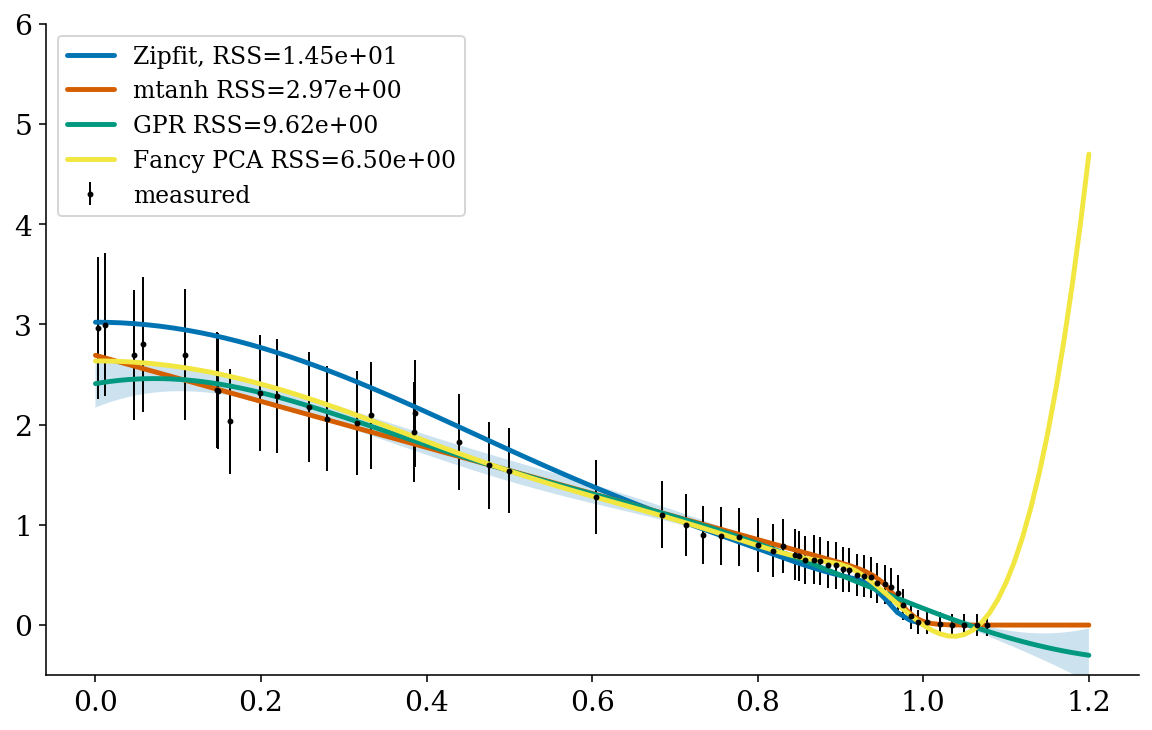

In [61]:
shot = shots[np.random.randint(len(shots))]
time = offline_data[shot]['time'][np.random.randint(len(offline_data[shot]['time']))]
sig = 'temp'

data = get_data(shot,time,sig)
if data is None:
    print('no data')
elif abs(data['times']['rt'] - data['times']['offline'])>50:
    print('too big time offset')
elif not np.all(np.isfinite(data['psi']+data['rt'])):
    print('nans')
else:
    x_meas = data['psi']
    y_meas = data['rt']/1000
    y_err = 0.2*y_meas + 0.1*np.mean(y_meas)
    y_err[np.abs(y_err)<1e-10] = 1e10

    y_true = data['zipfit']
    x_zip = np.linspace(0,1,65)
    x_true = np.linspace(0,1.2,121)
    
    zipRSS = np.sum((np.interp(x_meas,x_zip,y_true) - y_meas)**2/y_err**2)
    
    y_GPR, y_uncGPR, RSSGPR = GPR(x_true,x_meas,y_meas,y_err,kernel=square_exp_kernel)
    y_mtanh, RSSmtanh = fit_profile(x_true, x_meas,y_meas,y_err)
#     y_naive_pca = naive_pca_fit(x_true,x_meas,y_meas,sig,order=3)
    y_fancy_pca, B, L, RSSpca = fancy_pca_fit(x_true,x_meas,y_meas,y_err,sig,order=9, gamma=1e-14)
    fig, ax = plt.subplots()
    ax.plot(x_zip,y_true, label='Zipfit, RSS={:.2e}'.format(zipRSS))
    ax.plot(x_true,y_mtanh, label='mtanh RSS={:.2e}'.format(RSSmtanh))
    ax.plot(x_true,y_GPR, label='GPR RSS={:.2e}'.format(RSSGPR))
    ax.fill_between(x_true,y_GPR-2*np.diag(y_uncGPR),y_GPR+2*np.diag(y_uncGPR),alpha=0.2)
#     ax.plot(x_true,y_naive_pca, label='Naive PCA')
    ax.plot(x_true,y_fancy_pca, label='Fancy PCA RSS={:.2e}'.format(RSSpca))
    ax.errorbar(x_meas,y_meas,y_err,label='measured',c='k',marker='o',markersize=2,linestyle='',elinewidth=1)
    ax.legend()
    ax.set_ylim(-.5,6)


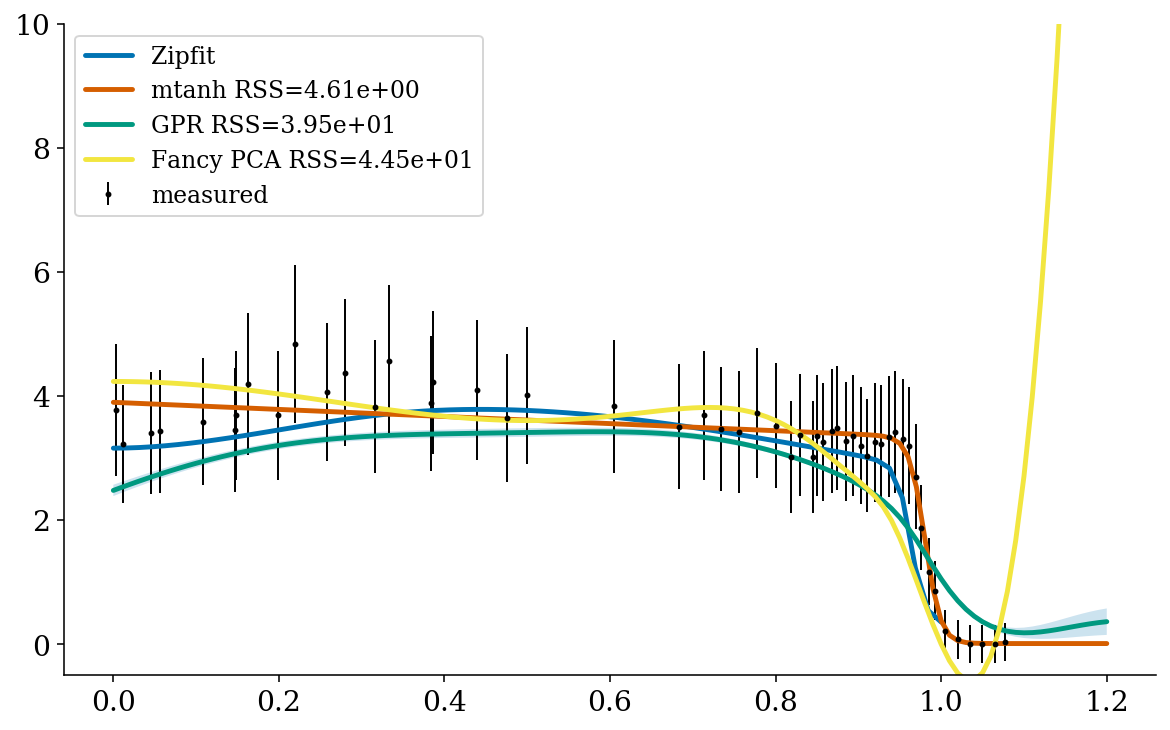

In [75]:
sig = 'dens'

data = get_data(shot,time,sig)
if data is None:
    print('no data')
elif abs(data['times']['rt'] - data['times']['offline'])>50:
    print('too big time offset')
else:
    x_meas = data['psi']
    y_meas = data['rt']/10**19
    y_err = 0.2*y_meas + 0.1*np.mean(y_meas)
    y_err[np.abs(y_err)<1e-10] = 1e10

    y_true = data['zipfit']
    x_zip = np.linspace(0,1,65)
    x_true = np.linspace(0,1.2,121)
    
    y_GPR, y_uncGPR, RSSGPR = GPR(x_true,x_meas,y_meas,y_err,kernel=gibbs_kernel)
    y_mtanh, RSSmtanh = fit_profile(x_true, x_meas,y_meas,y_err)
#     y_naive_pca = naive_pca_fit(x_true,x_meas,y_meas,sig,order=3)
    y_fancy_pca, B,L, RSSpca = fancy_pca_fit(x_true,x_meas,y_meas,y_err,sig,order=5)
    fig, ax = plt.subplots()
    ax.plot(x_zip,y_true, label='Zipfit')
    ax.plot(x_true,y_mtanh, label='mtanh RSS={:.2e}'.format(RSSmtanh))
    ax.plot(x_true,y_GPR, label='GPR RSS={:.2e}'.format(RSSGPR))
    ax.fill_between(x_true,y_GPR-np.diag(y_uncGPR),y_GPR+np.diag(y_uncGPR),alpha=0.2)
#     ax.plot(x_true,y_naive_pca, label='Naive PCA')
    ax.plot(x_true,y_fancy_pca, label='Fancy PCA RSS={:.2e}'.format(RSSpca))
    ax.errorbar(x_meas,y_meas,y_err,label='measured',c='k',marker='o',markersize=2,linestyle='',elinewidth=1)
    ax.legend()
    ax.set_ylim(-.5,10)


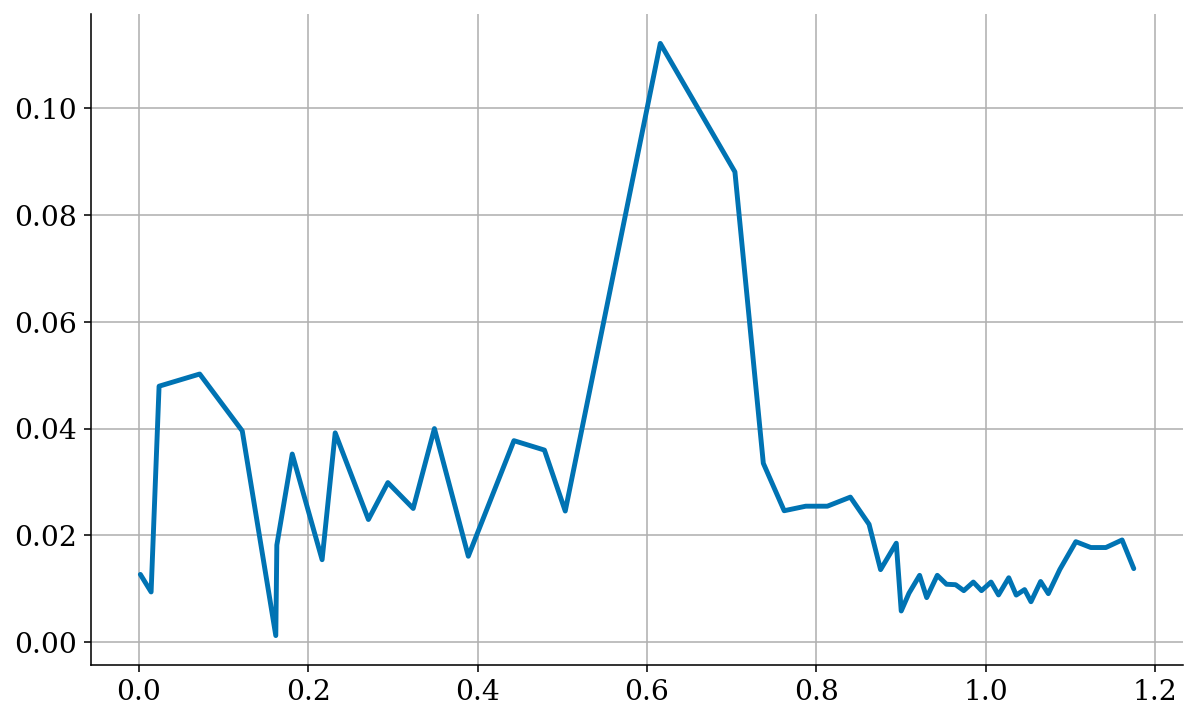

In [16]:
plt.plot(np.sort(x_meas[:-1]),np.diff(np.sort(x_meas)))
plt.grid()

In [108]:
n_meas = 40
y_err = 0.1*np.ones(x_meas.shape)
x_meas = np.sort(1.2*np.random.random(n_meas))
y_meas = np.interp(x_meas,xtrue,ytrue) + y_err*np.random.normal(size=x_meas.shape)

In [111]:
x121 = np.linspace(0,1.2,121)




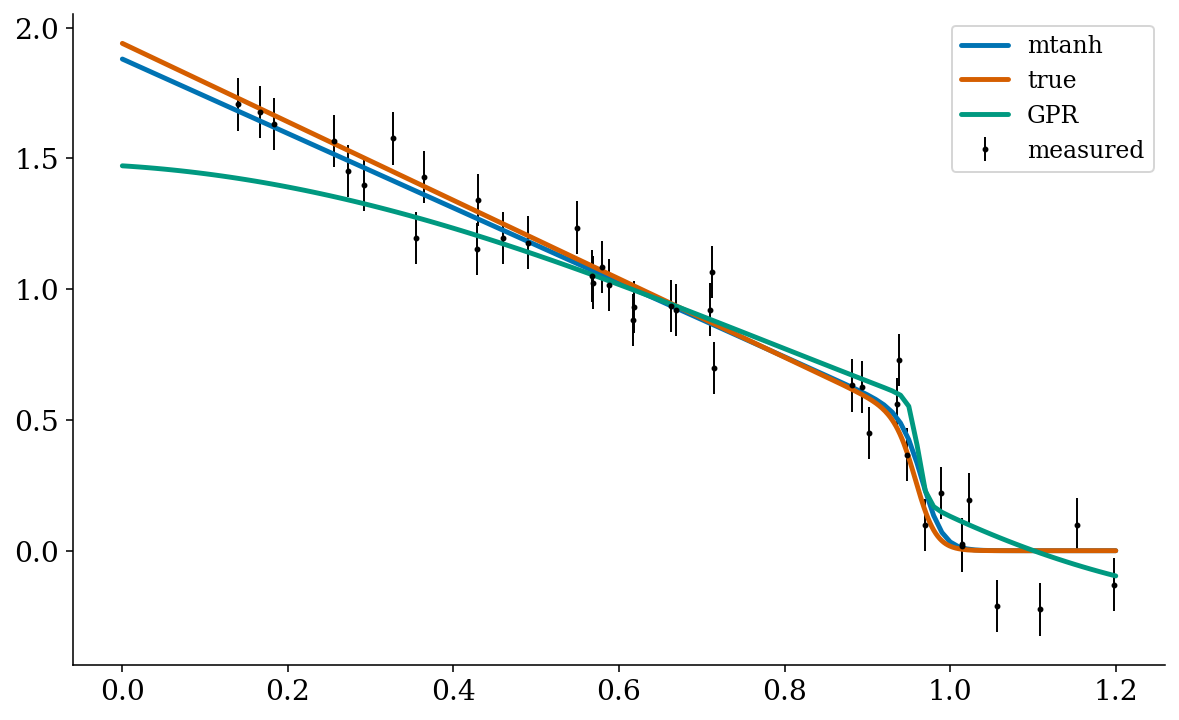

In [112]:
plt.plot(x121,y_mtanh,label='mtanh')
plt.plot(xtrue,ytrue,label='true')
plt.errorbar(x_meas,y_meas,y_err,label='measured',c='k',marker='o',markersize=2,linestyle='',elinewidth=1)
plt.plot(x121,yGPR,label='GPR')
plt.legend()

In [76]:
%%timeit
y_mtanh = fit_profile(x_meas,y_meas,y_err)[0]

/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


ValueError: Residuals are not finite in the initial point.

In [80]:
y_meas.size

53

In [83]:
%lprun -f GPR GPR(x_zip[:30],x_meas[:20],y_meas[:20],y_err[:20],kernel=square_exp_kernel)


Timer unit: 1e-06 s

Total time: 0.002482 s
File: <ipython-input-9-70324163c9b6>
Function: GPR at line 16

Line #      Hits         Time  Per Hit   % Time  Line Contents
    16                                           def GPR(xq,x,y,y_err,kernel=gibbs_kernel):
    17         1         34.0     34.0      1.4      y_err[np.abs(y_err)<1e-10] = 1e30
    18         1         45.0     45.0      1.8      sigma_n = np.diag(y_err)
    19                                               
    20         1        225.0    225.0      9.1      K1 = kernel(xq,x)
    21         1         73.0     73.0      2.9      K2 = kernel(x,x)
    22         1        237.0    237.0      9.5      K3 = kernel(xq,xq)
    23                                           
    24         1       1533.0   1533.0     61.8      temp = np.linalg.inv(K2+sigma_n)
    25         1        120.0    120.0      4.8      mu = np.matmul(np.matmul(K1,temp),y)
    26         1         59.0     59.0      2.4      unc = K3 - np.matmul(np.mat

In [20]:
%%timeit
y_naive_pca = naive_pca_fit(x_true,x_meas,y_meas,sig,order=7)


148 µs ± 4.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [118]:
def foo(n):
    for i in range(n): 
        x_true = np.linspace(0,1,65)
        x_meas = np.random.random(40)
        y_meas = np.random.random(40)
        y_err = np.random.random(40)
        sig = 'temp'
        fancy_pca_fit(x_true,x_meas,y_meas,y_err,sig,order=9)

%lprun -f fancy_pca_fit foo(1000)



Timer unit: 1e-06 s

Total time: 2.50992 s
File: <ipython-input-98-a8a188b815c3>
Function: fancy_pca_fit at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def fancy_pca_fit(xq,x_meas,y_meas,y_err,sig,order=None,var_cutoff=.95,gamma=1e-2):
     2      1000       3151.0      3.2      0.1      fitter = full_pca_fitter[sig]
     3      1000       2608.0      2.6      0.1      if order is None:
     4                                                   order = np.where(np.cumsum(fitter.explained_variance_ratio_)>var_cutoff)[0][0]
     5      1000      40717.0     40.7      1.6      S = np.diag(np.abs(np.log(np.concatenate(([1],fitter.explained_variance_ratio_[:order])))))
     6      1000      25519.0     25.5      1.0      W = np.diag(1/y_err)
     7      1000     974017.0    974.0     38.8      X = np.stack([basis_fns[sig][i](x_meas) for i in range(order+1)],axis=1)
     8      1000      13111.0     13.1      0.5      

In [119]:
%%timeit
y_fancy_pca, B,L, RSSpca = fancy_pca_fit(x_true,x_meas,y_meas,y_err,sig,order=5)


687 µs ± 293 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [96]:
A = np.matrix(np.random.random((3,3)))

In [43]:
len(x_true)

121

In [65]:
%load_ext line_profiler

In [70]:
%lprun?

Docstring:
Execute a statement under the line-by-line profiler from the
line_profiler module.

Usage:
  %lprun -f func1 -f func2 <statement>

The given statement (which doesn't require quote marks) is run via the
LineProfiler. Profiling is enabled for the functions specified by the -f
options. The statistics will be shown side-by-side with the code through the
pager once the statement has completed.

Options:

-f <function>: LineProfiler only profiles functions and methods it is told
to profile.  This option tells the profiler about these functions. Multiple
-f options may be used. The argument may be any expression that gives
a Python function or method object. However, one must be careful to avoid
spaces that may confuse the option parser.

-m <module>: Get all the functions/methods in a module

One or more -f or -m options are required to get any useful results.

-D <filename>: dump the raw statistics out to a pickle file on disk. The
usual extension for this is ".lprof". These stat